Mnist分类任务


In [70]:
import torch

print(torch.__version__)

2.6.0+cpu


In [71]:
#已经下载完，不需要了
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [72]:
import pickle
import gzip

# as_posix转换为字符串，pickle.load 加载数据，指定编码 
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

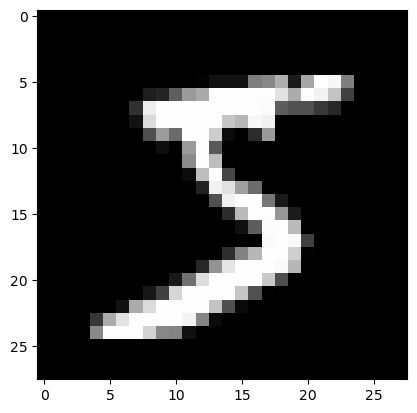

5


In [73]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.show()
print(y_train[0])

![4](img/4.png) 

![5](img/5.png) 

In [74]:
#神经网络中需要将数据转换为tensor后才能参与后续建模训练
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
print(y_train[0])

tensor(5)


In [75]:
n, c = x_train.shape
print(n, c)
print(x_train)
print(y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

50000 784
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


一般情况，如果模型有可学习的参数，使用nn.module,其它情况下一般使用nn.functional更简单一些<br/>
下面为最简单的计算损失的一个案例 使用wx+b

In [76]:
import torch.nn.functional as F

loss_func = F.cross_entropy


# y=wx+b
def model(xb):
    return xb.mm(weights) + bias

In [77]:
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
#28*28 的图片展开 784，最终输出类别0-9 10 requires_grad True 表示该张良需要被追踪，后续会自动进行学习更新
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
#偏置
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(11.2014, grad_fn=<NllLossBackward0>)


创建一个model来更简化代码
- 必须继承nn.Module并且构造函数调用nn.Module的构造函数
- 无需编写反向传播函数,nn.MOdule中能够利用autograd自动实现反向传播
- Module中的科学系参数可以通过named_parameters()或parameters()返回迭代器

In [78]:
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #全连接之间的隐层，b偏置会自动带上，不需要手动传递
        self.hidden1 = nn.Linear(784, 128)
        #最终是要10分类，起始是基于图片的大小决定，所以除784开始和10结尾中间可以任意定义
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)

    #编写前向传播代码
    def forward(self, x):
        #F.relu激活函数，relu相对sigmoid可以避免梯度消失的现象,同时可以引入非线性，使网络学习到更复杂的数据模式
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [79]:
#输出结果可以看到包含了偏置 bias
net = Net()
print(net)

Net(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [80]:
#查看定义好的初始化后的权重以及偏置
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[-1.7906e-02, -2.7132e-02, -1.5420e-02,  ...,  8.4504e-03,
         -3.1428e-02, -1.4126e-02],
        [ 3.2337e-02, -1.1683e-02,  1.0460e-02,  ...,  9.9219e-03,
         -5.9418e-06, -3.5078e-02],
        [ 1.7009e-02, -2.6369e-02,  9.4181e-03,  ...,  1.8662e-02,
          1.7380e-02,  5.0159e-04],
        ...,
        [ 1.3711e-02, -3.2325e-02, -1.2599e-02,  ...,  2.6296e-02,
          3.4836e-02, -1.6863e-02],
        [-6.0423e-03,  3.2004e-02,  1.5382e-03,  ...,  2.4837e-02,
          2.6973e-02, -2.7640e-02],
        [-3.2945e-02,  7.2541e-03,  1.4811e-02,  ..., -1.3387e-02,
         -1.5132e-02,  2.7999e-02]], requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 6.1110e-03, -1.8698e-02, -1.9365e-02, -2.4203e-02,  2.1168e-02,
         1.1775e-02, -7.7508e-03,  2.1569e-02, -2.8920e-02, -2.0105e-02,
        -2.6301e-02,  3.0967e-02,  2.5004e-03,  1.7047e-02,  2.7886e-02,
        -4.1679e-03, -2.6320e-02, 

In [81]:
#使用TensorDataset 和DataLoader简化
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

#TensorDataset 将多个张量组合成数据集对象(Dataset对象)
train_ds = TensorDataset(x_train, y_train)
#DataLoader 生成批训练数据，将Dataset对象按批次加载，支持自动分批，打乱数据，多线程加载,是训练循环中数据供应的管道
train_d1 = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)

valid_ds = TensorDataset(x_valid, y_valid)
valid_d1 = DataLoader(valid_ds, batch_size=bs)

In [82]:
print(train_ds.tensors)
print(train_d1)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4,  ..., 8, 4, 8]))


In [83]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2, shuffle=True)
    )

In [114]:
import numpy as np


def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        #切换到训练模式,训练模式下 会
        #1.启用Dropout层，会按照指定p随机丢弃部分神经元 防止过拟合
        #2 BatchNorm层，会使用当前批次的均值和方差做归一化，并更新统计量(running_mean和running_var)
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        #预测模式
        model.eval()
        #with torch.no_grad 临时禁用梯度计算 再验证，测试，预测阶段，无需反向传播，不需计算梯度，禁用后可以提升效率
        with torch.no_grad():
            losses, nums = zip(
                #这里不需要传递opt进行参数学习，传递了会由于当前是no_grad模式而报错  element 0 of tensors does not require grad and does not have a grad_fn
                *[loss_batch(model, loss_func, x, y) for x, y in valid_dl]
            )
        #计算平均损失    
        #加入三次损失各是0.8，0.6，0.4，三次数据大小各是 64，64，32
        #计算平均损失的方法:total_loss = (0.8*64 + 0.6*64 + 0.4*32) / (64+64+32)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step' + str(step), '验证集损失: ', val_loss)

    losses, nums = zip(
                *[loss_batch(model, loss_func, x, y, opt) for x, y in valid_dl]
            )
功能说明
快速计算验证集中所有批次的损失，并分离损失值/样本数

关键步骤
遍历批次：
[loss_batch(...) for x,y in valid_dl]
→ 生成 [(loss1, num1), (loss2, num2)...]

解包重组：
zip(*[...])
→ 将元组列表转换为 (losses_tuple, nums_tuple)

结果赋值：
→ losses：所有批次的损失值元组
→ nums：所有批次的样本数元组

典型应用
python
复制
# 计算加权平均损失
avg_loss = sum(l * n for l,n in zip(losses, nums)) / sum(nums)
输出示例
losses = (0.32, 0.28, 0.41)
nums = (64, 64, 32) → 总样本数 160

In [108]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    #损失计算方法基于预测值和标签值
    loss = loss_func(model(xb), yb)
    #优化器 反向传播与参数更新
    if opt is not None:
        #计算梯度(反向传播)
        loss.backward()
        #更新模型参数(仅更新标记需要更新的参数)
        opt.step()
        #梯度清空，避免累计
        opt.zero_grad()
    #loss.item()将损失从张量转换为python浮点数，len为当前批次的样本数量，虽然设置64一批次，但可能数据不足时会低于64
    return loss.item(), len(xb)


In [86]:
from torch import optim

def get_model():
    model = Net()
    #optim.SGD 随机梯度下降（SGD） model.parameters 需要训练的参数(权重,偏置)，lr 学习率 
    return model, optim.SGD(model.parameters(), lr=0.001)

In [115]:
train_dl,valid_dl=get_data(train_ds, valid_ds, bs)
model,opt=get_model()
fit(25,model,loss_func,opt,train_dl,valid_dl)

当前step0 验证集损失:  2.279741432189941
当前step1 验证集损失:  2.246731374359131
当前step2 验证集损失:  2.1922055141448973
当前step3 验证集损失:  2.1010790191650393
当前step4 验证集损失:  1.9565008152008057
当前step5 验证集损失:  1.7452244747161865
当前step6 验证集损失:  1.483807622718811
当前step7 验证集损失:  1.228487015914917
当前step8 验证集损失:  1.0222397081375123
当前step9 验证集损失:  0.8694234760284424
当前step10 验证集损失:  0.7583453384399415
当前step11 验证集损失:  0.6771698937416076
当前step12 验证集损失:  0.6158935648918152
当前step13 验证集损失:  0.569078995513916
当前step14 验证集损失:  0.5322226259231567
当前step15 验证集损失:  0.5027647064208984
当前step16 验证集损失:  0.47891981739997863
当前step17 验证集损失:  0.4584455547809601
当前step18 验证集损失:  0.4417563949584961
当前step19 验证集损失:  0.4274991028308868
当前step20 验证集损失:  0.41456771824359895
当前step21 验证集损失:  0.40387819423675536
当前step22 验证集损失:  0.39397630615234375
当前step23 验证集损失:  0.3854663252830505
当前step24 验证集损失:  0.3776231855392456
